# Python for Engineering Analysis

By

**Olagoke Oladokun**  
**Bemgba Bevan Nyakuma**  
**Arshad Ahmad**

---

# Advance Modelling and Simulation (Kinetic Study: Model Free)

Install the following packages into your python environment.
1. numpy
2. xlrd
3. pandas
4. scipy
5. matplotlib


In [1]:
%pip install numpy xlrd pandas scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


## Kinetic Study: Model Free

### Isoconversion Methods

#### Import modules

In [2]:
import numpy as np
import numpy.polynomial.polynomial as npp
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [3]:
def maximumConversionTemperature(dfeDict, a):
    
    # dfIsoConvDict = isoconversion(dfeDict, a)
        
    for (B,v) in dfeDict.items():
        # get maximum conversion row
        i = v['DXDT'].idxmax()
        dfMaxDict[B] = v.loc[i,['T']][0]
    
    return dfMaxDict

In [4]:
def isoconversion(dfeDict, a):
    # get isoconversion model
    dfIsoConvDict = {}
    
    for (B,v) in dfeDict.items():

        # calculate conversion for each heating rate
        mo = v.iloc[0]['TGA']
        mf = v.iloc[-1]['TGA']
        v['X'] = (mo - v['TGA'])/(mo - mf)

        (m,n) = v.shape

        # compute derivative of conversion with temperature
        # using forward, center and backward difference
        dfDXDT = v['X'].copy()
        dfDXDT.columns = ['DXDT']
        dfDXDT['DXDT'] = 0

        x2 = v.iloc[1]['X']
        x1 = v.iloc[0]['X']
        T2 = v.iloc[1]['T']
        T1 = v.iloc[0]['T']
        dfDXDT.iloc[0] = (x2-x1)/(T2-T1)

        for j in range(1,m-1):  
            x2 = v.iloc[j+1]['X']
            x1 = v.iloc[j-1]['X']
            T2 = v.iloc[j+1]['T']
            T1 = v.iloc[j-1]['T']
            dfDXDT.iloc[j] = (x2-x1)/(T2-T1)

        x2 = v.iloc[m-1]['X']
        x1 = v.iloc[m-2]['X']
        T2 = v.iloc[m-1]['T']
        T1 = v.iloc[m-2]['T']
        dfDXDT.iloc[m-1] = (x2-x1)/(T2-T1)

        v['DXDT'] = dfDXDT

        # get maximum conversion row
#         dfMaxDict[B] = v.loc[v['DXDT'].idxmax()]   

        # get values at specified conversions   
        Xp = v['X'].to_numpy(float)
        Tp = v['T'].to_numpy(float)
        tp = v['t'].to_numpy(float)
        TGAp = v['TGA'].to_numpy(float)
        DTGp = v['DTG'].to_numpy(float)
        DXDTp = v['DXDT'].to_numpy(float)

        Xx = 100 - TGAp

#         a = alpha
        Ta = np.interp(a, Xx, Tp)
        ta = np.interp(a, Xx, tp)
        TGAa = np.interp(a, Xx, TGAp)
        DTGa = np.interp(a, Xx, DTGp)
        Xa = np.interp(a, Xx, Xp)
        DXDTa = np.interp(Xa, Xx, DXDTp)

        dfA = pd.DataFrame({'a': a,
                            'T': Ta,
                            't': ta,
                            'TGA': TGAa,
                            'DTG': DTGa,
                            'X': Xa,
                            'DXDT': DXDTa})

        # compute X and Y for ploting
        dfA['TK'] = dfA['T'] + 273.15

        dfIsoConvDict[B] = dfA
    
    return dfIsoConvDict
    

In [5]:
# get points
def getPoints(dfIsoConvDict, a, A, k, C):
    dfPoints = pd.DataFrame({'a': a, 
                            })
    for (B,v) in dfIsoConvDict.items():
        dfA = v.copy()

        dfA['Xp'] = 1000.0 / dfA['TK'];
        dfA['Yp'] = np.log((B) / (dfA['TK']**k));

        # concat X and Y
        dfPoints = pd.concat([dfPoints, dfA[['Xp','Yp']]], axis=1)
    
    return dfPoints

In [6]:
# get model free details
def getModelFree(dfIsoConvDict, R, a, A, k, C):
    
    M = len(a)
    
    dfPoints = getPoints(dfIsoConvDict, a, A, k, C)
    
    dfModelFree = pd.DataFrame({'a': a, 
                            })

    xList=[]
    yList=[]
    coeffList=[]
    yPredList=[]

    aR2 = np.zeros(M)
    aEa = np.zeros(M)
    ako = np.zeros(M)


    for i in range(M):
        x = dfPoints.iloc[i]['Xp'].to_numpy()
        y = dfPoints.iloc[i]['Yp'].to_numpy()

        coeff, stats = npp.polyfit(x,y,1,full=True)
        # compute function
        yPred = npp.polyval(x, coeff)

        # compute R-Squared
        SSR = stats[0][0]
        SST = np.linalg.norm(y-np.mean(y))**2
    #     SST = np.sum((y-np.mean(y))**2)
        R2 = 1 - SSR/SST

        # compute Ea and ko
        Ea = -(coeff[1] * R / A)
        ko = np.exp(coeff[0]+C) * ((Ea / R)**(k-1))

    #     aCoeff[i] = coeff
        aR2[i] = R2
        aEa[i] = Ea
        ako[i] = ko

    #     aList.insert(i,(stats[0][0], coeff[1], coeff[0]))
    #     aCoeff.insert(i,coeff)
        xList.insert(i,x)
        yList.insert(i,y)
        coeffList.insert(i,coeff)
        yPredList.insert(i,yPred)

    dfModelFree['X'] = xList
    dfModelFree['Y'] = yList
    dfModelFree['Coeff'] = coeffList
    dfModelFree['YPred'] = yPredList

    dfModelFree['R2'] = aR2
    dfModelFree['Ea'] = aEa
    dfModelFree['ko'] = ako
    
    return dfModelFree

In [7]:
def bestModelPlot(dfModelFree, rSquared):
    # get best models 
    dfMF = dfModelFree[dfModelFree['R2'] > rSquared]
    (M,N) = dfMF.shape

    markers_cycler = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D','8', 'p','*','h','H','d','+','X',))
    
    fig, ax = plt.subplots()
    for i in range(M):
        a = dfMF.iloc[i]['a']
        x = dfMF.iloc[i]['X']
        y = dfMF.iloc[i]['Y']
        yPred = dfMF.iloc[i]['YPred']

        color = next(ax._get_lines.prop_cycler)['color']

        ax.plot(x,y,linestyle='', markeredgecolor='none', marker=next(markers_cycler), color=color)
        ax.plot(x,yPred,color=color,label=a)
    #     ax.legend()

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    return dfMF

### Load the TGA Excel file

In [8]:
# load tga data from file
# TGA file format
# Temp (C) | t (min) | m (g-%) | DTG (%/min)

In [9]:
df = pd.read_excel('rawtga.xlsx')

In [10]:
df

,Temp_5,Time_5,TGA_5,DTG_5,Unnamed: 4,Temp_10,Time_10,TGA_10,DTG_10,Unnamed: 9,Temp_15,Time_15,TGA_15,DTG_15,Unnamed: 14,Temp_20,Time_20,TGA_20,DTG_20
0,C,min,%,-,NaN,C,min,%,-,NaN,C,min,%,-,NaN,C,min,%,-
1,5,5,5,5,NaN,10,10,10,10,NaN,15,15,15,15,NaN,20,20,20,20
2,4.8,4.8,4.8,4.8,NaN,9,9,9,9,NaN,8.3,8.3,8.3,8.3,NaN,7.7,7.7,7.7,7.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29.692,0,100,0.61361,NaN,30.945,0,100,-0.53178,NaN,27.457,0,100,-0.27409,NaN,27.043,0,100,-0.22254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,979.692,189.995,7.69563,-0.32573,NaN,980.945,95.1521,20.0334,-0.19303,NaN,977.457,63.2391,24.6772,-0.23183,NaN,977.043,47.4317,23.4953,-0.33824
195,984.692,190.993,7.3536,-0.34381,NaN,985.945,95.6514,19.9318,-0.20141,NaN,982.457,63.5715,24.5971,-0.23097,NaN,982.043,47.6798,23.3982,-0.3434
196,989.692,191.99,7.00465,-0.33146,NaN,990.945,96.1509,19.8339,-0.20271,NaN,987.457,63.9038,24.5256,-0.23149,NaN,987.043,47.928,23.3154,-0.33808
197,994.692,192.99,6.67997,-0.32714,NaN,995.945,96.6498,19.7313,-0.20892,NaN,992.457,64.2358,24.4476,-0.2453,NaN,992.043,48.1759,23.2388,-0.33378


In [11]:
i_h = 1
i_m = 2
i_d = 4

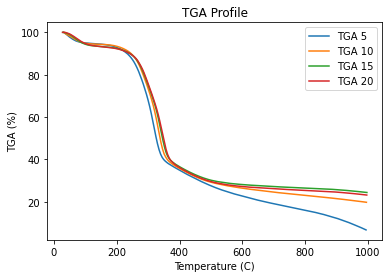

In [12]:
fig, ax = plt.subplots()

df_raw = df.loc[i_d:]

x1 = df.loc[i_d:,'Temp_5']
y1 = df.loc[i_d:,'TGA_5']
x2 = df_raw['Temp_10']
y2 = df_raw['TGA_10']

ax.plot(x1,y1, label='TGA 5')
ax.plot(x2,y2, label='TGA 10')
ax.plot(df_raw['Temp_15'], df_raw['TGA_15'], label='TGA 15')
ax.plot(df_raw['Temp_20'], df_raw['TGA_20'], label='TGA 20')

ax.set_xlabel('Temperature (C)')  # Add a y-label to the axes.
ax.set_ylabel('TGA (%)')  # Add a y-label to the axes.
ax.set_title("TGA Profile")  # Add a title to the axes.
# ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
ax.legend()

fname = 'tga_Temp'

plt.savefig(fname, format="svg")
plt.show()

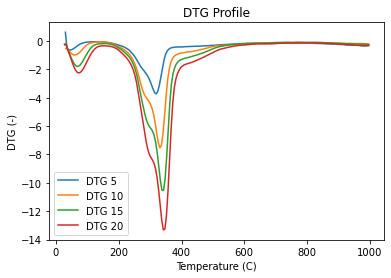

In [13]:
df_raw = df.loc[i_d:]

x1 = df.loc[i_d:,'Temp_5']
y1 = df.loc[i_d:,'DTG_5']
x2 = df_raw['Temp_10']
y2 = df_raw['DTG_10']

fig, ax = plt.subplots()

ax.plot(x1,y1, label='DTG 5')
ax.plot(x2,y2, label='DTG 10')
ax.plot(df_raw['Temp_15'], df_raw['DTG_15'], label='DTG 15')
ax.plot(df_raw['Temp_20'], df_raw['DTG_20'], label='DTG 20')

ax.set_xlabel('Temperature (C)')  # Add a y-label to the axes.
ax.set_ylabel('DTG (-)')  # Add a y-label to the axes.
ax.set_title("DTG Profile")  # Add a title to the axes.
# ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
ax.legend()

fname = 'dtg_time'

plt.savefig(fname, format="svg")
plt.show()

In [14]:
(Rows, Cols) = df.shape

In [15]:
N = round(Cols/5)
N

4

In [16]:
# get each experiment data

In [17]:
# create list of TGA 

In [18]:
heatRateList = []
massList = []
dfeList =[]
dfeDict= {}
dfMaxDict = {}
dfIsoConvDict= {}

In [19]:
a = 0
b = a+3

In [20]:
for i in range(N):
    heatingRate = df.iloc[i_h, a]
    heatRateList.insert(i, heatingRate)
    mass = df.iloc[i_m, a]
    massList.insert(i, mass)
    
    dfe = df.iloc[i_d:,a:(b+1)].astype('float')
    
    dfe.columns = ['T', 't', 'TGA', 'DTG',]
    # dfeList.append(dfe)
    
    dfeDict[heatRateList[i]] = dfe.dropna(how='all')
    a = b+2
    b = a+3  
    

In [21]:
heatRateList

[5, 10, 15, 20]

In [22]:
massList

[4.8, 9, 8.3, 7.7]

In [23]:
dfeDict

{5:            T          t        TGA      DTG
 4     29.692    0.00000  100.00000  0.61361
 5     34.692    1.63523   99.63026 -0.50031
 6     39.692    2.66807   99.00546 -0.61951
 7     44.692    3.61761   98.41193 -0.63960
 8     49.692    4.55174   97.77192 -0.61778
 ..       ...        ...        ...      ...
 193  974.692  188.99578    7.99745 -0.32813
 194  979.692  189.99495    7.69563 -0.32573
 195  984.692  190.99338    7.35360 -0.34381
 196  989.692  191.98951    7.00465 -0.33146
 197  994.692  192.99033    6.67997 -0.32714
 
 [194 rows x 4 columns],
 10:            T         t        TGA      DTG
 4     30.945   0.00000  100.00000 -0.53178
 5     35.945   1.15249   99.41895 -0.59022
 6     40.945   1.78178   99.01448 -0.70916
 7     45.945   2.31515   98.61156 -0.82800
 8     50.945   2.80751   98.16741 -0.92455
 ..       ...       ...        ...      ...
 193  975.945  94.65279   20.12871 -0.18500
 194  980.945  95.15213   20.03345 -0.19303
 195  985.945  95.65136   19.9

In [24]:
# compute fractional converstion x
# x = (mo - mt)/(mo - mf)
# dx/dT

In [25]:
# create conversion points
startX=0
endX=100
h=5
aRows=int((endX-startX)/h)+1
alpha = np.linspace(startX, endX, num=aRows)

In [26]:
alpha

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [27]:
dfIsoConvDict = isoconversion(dfeDict, alpha)

In [28]:
dfeDict[5]

,T,t,TGA,DTG,X,DXDT
4,29.692,0.00000,100.00000,0.61361,0.000000,0.000792
5,34.692,1.63523,99.63026,-0.50031,0.003962,0.001066
6,39.692,2.66807,99.00546,-0.61951,0.010657,0.001306
7,44.692,3.61761,98.41193,-0.63960,0.017017,0.001322
8,49.692,4.55174,97.77192,-0.61778,0.023876,0.001266
...,...,...,...,...,...,...
193,974.692,188.99578,7.99745,-0.32813,0.985882,0.000695
194,979.692,189.99495,7.69563,-0.32573,0.989116,0.000690
195,984.692,190.99338,7.35360,-0.34381,0.992782,0.000740
196,989.692,191.98951,7.00465,-0.33146,0.996521,0.000722


In [29]:
dfIsoConvDict[5.0]

,a,T,t,TGA,DTG,X,DXDT,TK
0,0.0,29.692000,0.000000,100.00000,0.613610,0.000000,0.000792,302.842000
1,5.0,100.016472,14.374152,95.00000,-0.076401,0.053579,0.000832,373.166472
2,10.0,232.850469,40.714068,90.00000,-0.646463,0.107158,0.000872,506.000469
3,15.0,258.651651,45.867650,85.00000,-1.386879,0.160737,0.000911,531.801651
4,20.0,273.702299,48.870647,80.00000,-1.920984,0.214316,0.000951,546.852299
5,25.0,285.696317,51.267006,75.00000,-2.266513,0.267895,0.000990,558.846317
6,30.0,295.990838,53.321421,70.00000,-2.634575,0.321474,0.001030,569.140838
7,35.0,304.824485,55.083469,65.00000,-3.117499,0.375053,0.001068,577.974485
8,40.0,312.244654,56.564393,60.00000,-3.540875,0.428633,0.001088,585.394654
9,45.0,319.027003,57.918061,55.00000,-3.720995,0.482212,0.001109,592.177003


### Flynn Wall Ozawa (FWO)

In [30]:
# FWO
R = 8.314
rSquared = 0.9

A = 1.0518
k = 0
C = 5.331
    


In [31]:
# FWO
   
df_FWO_ModelFree = getModelFree(dfIsoConvDict, R, alpha, A, k, C)

df_FWO_ModelFree

,a,X,Y,Coeff,YPred,R2,Ea,ko
0,0.0,"[3.302051895047583, 3.28844604482152, 3.326602...","[1.6094379124341003, 2.302585092994046, 2.7080...","[25.65502861502932, -7.059791715081902]","[2.3432300036018994, 2.4392844723045073, 2.169...",0.117152,55.804438,4.267785e+12
1,5.0,"[2.6797691534691794, 2.721536684959922, 2.7552...","[1.6094379124341003, 2.302585092994046, 2.7080...","[-34.55779786388203, 13.60033470303852]","[1.8879595501770083, 2.456011958170812, 2.9149...",0.490902,-107.504452,-1.568002e-14
2,10.0,"[1.9762827543793888, 1.9283230635692525, 1.942...","[1.6094379124341003, 2.302585092994046, 2.7080...","[41.20059851783791, -19.919373974266698]","[1.8342832544610062, 2.789610271398317, 2.5137...",0.452698,157.453580,8.532454e+18
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[1.6094379124341003, 2.302585092994046, 2.7080...","[48.47706086358223, -24.951654286180975]","[1.557961888634523, 2.522603129086889, 2.72720...",0.920076,197.231464,9.848673e+21
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[1.6094379124341003, 2.302585092994046, 2.7080...","[49.12231350704279, -26.009281218086805]","[1.560510660241924, 2.4413639640431555, 2.7420...",0.964823,205.591523,1.801268e+22
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[1.6094379124341003, 2.302585092994046, 2.7080...","[48.25992533240656, -26.096987137241857]","[1.5619578342722917, 2.4326958751094736, 2.749...",0.966581,206.284798,7.578547e+21
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[1.6094379124341003, 2.302585092994046, 2.7080...","[44.71933571385553, -24.56082109528386]","[1.565129484106805, 2.4173987815544464, 2.7638...",0.968450,194.142106,2.334936e+20
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[1.6094379124341003, 2.302585092994046, 2.7080...","[41.118835377026706, -22.857048485498865]","[1.572023063147391, 2.3861684765580833, 2.7695...",0.978089,180.674559,6.852045e+18
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[1.6094379124341003, 2.302585092994046, 2.7080...","[38.861470903088644, -21.82415349809821]","[1.5803762709200981, 2.357029861353176, 2.7647...",0.987319,172.509994,7.508307e+17
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[1.6094379124341003, 2.302585092994046, 2.7080...","[38.07307783826852, -21.60568078851368]","[1.587904168319021, 2.3360014457258345, 2.7618...",0.991887,170.783067,3.447599e+17


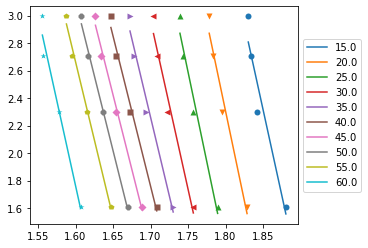

In [32]:
dfFWO_best = bestModelPlot(df_FWO_ModelFree, rSquared)

In [33]:
dfFWO_best

,a,X,Y,Coeff,YPred,R2,Ea,ko
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[1.6094379124341003, 2.302585092994046, 2.7080...","[48.47706086358223, -24.951654286180975]","[1.557961888634523, 2.522603129086889, 2.72720...",0.920076,197.231464,9.848673e+21
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[1.6094379124341003, 2.302585092994046, 2.7080...","[49.12231350704279, -26.009281218086805]","[1.560510660241924, 2.4413639640431555, 2.7420...",0.964823,205.591523,1.801268e+22
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[1.6094379124341003, 2.302585092994046, 2.7080...","[48.25992533240656, -26.096987137241857]","[1.5619578342722917, 2.4326958751094736, 2.749...",0.966581,206.284798,7.578547e+21
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[1.6094379124341003, 2.302585092994046, 2.7080...","[44.71933571385553, -24.56082109528386]","[1.565129484106805, 2.4173987815544464, 2.7638...",0.968450,194.142106,2.334936e+20
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[1.6094379124341003, 2.302585092994046, 2.7080...","[41.118835377026706, -22.857048485498865]","[1.572023063147391, 2.3861684765580833, 2.7695...",0.978089,180.674559,6.852045e+18
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[1.6094379124341003, 2.302585092994046, 2.7080...","[38.861470903088644, -21.82415349809821]","[1.5803762709200981, 2.357029861353176, 2.7647...",0.987319,172.509994,7.508307e+17
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[1.6094379124341003, 2.302585092994046, 2.7080...","[38.07307783826852, -21.60568078851368]","[1.587904168319021, 2.3360014457258345, 2.7618...",0.991887,170.783067,3.447599e+17
10,50.0,"[1.6694091435339389, 1.6362039007258782, 1.615...","[1.6094379124341003, 2.302585092994046, 2.7080...","[38.07315840243007, -21.851327918827046]","[1.5943517763817638, 2.3199304256049658, 2.761...",0.994006,172.724796,3.409116e+17
11,55.0,"[1.6470030524650785, 1.6159169343558961, 1.595...","[1.6094379124341003, 2.302585092994046, 2.7080...","[38.88772299592863, -22.639359499705428]","[1.6006287940595172, 2.304398597383596, 2.7714...",0.993293,178.953827,7.430472e+17
12,60.0,"[1.6066971017010063, 1.5773530098481554, 1.556...","[1.6094379124341003, 2.302585092994046, 2.7080...","[41.39345353429471, -24.768636193182584]","[1.5977575496216048, 2.3245706851442023, 2.834...",0.967202,195.784789,8.321534e+18


In [34]:
dfFWO_best[['R2','Ea','ko']].mean()

R2    9.731728e-01
Ea    1.874681e+02
ko    3.569075e+21
dtype: float64

### Kissinger KAS

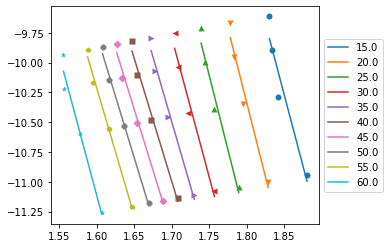

In [35]:
# KAS
R = 8.314
rSquared = 0.9

A = 1;
k = 2;
C = 0;
    
df_KAS_ModelFree = getModelFree(dfIsoConvDict, R, alpha, A, k, C)
df_KAS_best = bestModelPlot(df_KAS_ModelFree, rSquared)

In [36]:
df_KAS_ModelFree

,a,X,Y,Coeff,YPred,R2,Ea,ko
0,0.0,"[3.302051895047583, 3.28844604482152, 3.326602...","[-9.816984522287306, -9.132095212182488, -8.70...","[12.221747086805557, -6.452044985924131]","[-9.083240285897475, -8.995454728167168, -9.24...",0.099793,53.642302,1.310795e+06
1,5.0,"[2.6797691534691794, 2.721536684959922, 2.7552...","[-10.234611337435075, -9.510532107999754, -9.0...","[-48.37415583311103, 14.336369534096619]","[-9.955994982903604, -9.3572002169253, -8.8734...",0.517162,-119.192576,-1.405433e-20
2,10.0,"[1.9762827543793888, 1.9283230635692525, 1.942...","[-10.843637278709748, -10.199623972484238, -9....","[26.724779725555166, -18.895846023247802]","[-10.618754899597825, -9.712515966726912, -9.9...",0.426636,157.100064,7.634678e+12
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[-10.943103253303097, -10.291503999446922, -9....","[33.89880824129125, -23.874367903277413]","[-10.994561062826207, -10.07156815802356, -9.8...",0.913393,198.491495,1.258917e+16
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[-10.998919578246015, -10.343160055969626, -9....","[34.4872768697042, -24.900967145337486]","[-11.047810398975216, -10.204492239049927, -9....",0.961796,207.026641,2.365104e+16
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[-11.04231110774403, -10.3868083214063, -9.995...","[33.58092572091228, -24.964043726915722]","[-11.089752026324447, -10.256815166148428, -9....",0.963643,207.551060,9.579121e+15
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[-11.078817931344723, -10.425564784115993, -10...","[30.00144467281091, -23.40564519066042]","[-11.123077816872271, -10.310893537463823, -9....",0.965425,194.594534,2.504854e+14
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[-11.109621536201582, -10.458077839923522, -10...","[26.366920475596366, -21.682070580485544]","[-11.146968352470829, -10.37467448751498, -10....",0.975766,180.264735,6.125038e+12
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[-11.135134572036245, -10.484092244024136, -10...","[24.08148860070048, -20.63258348647103]","[-11.164107409805688, -10.429858081598098, -10...",0.985885,171.539299,5.929407e+11
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[-11.158173250203784, -10.506460615582279, -10...","[23.268941775608447, -20.399637595374944]","[-11.17960570394947, -10.473267704486894, -10....",0.990950,169.602587,2.601330e+11


In [37]:
df_KAS_best

,a,X,Y,Coeff,YPred,R2,Ea,ko
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[-10.943103253303097, -10.291503999446922, -9....","[33.89880824129125, -23.874367903277413]","[-10.994561062826207, -10.07156815802356, -9.8...",0.913393,198.491495,1.258917e+16
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[-10.998919578246015, -10.343160055969626, -9....","[34.4872768697042, -24.900967145337486]","[-11.047810398975216, -10.204492239049927, -9....",0.961796,207.026641,2.365104e+16
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[-11.04231110774403, -10.3868083214063, -9.995...","[33.58092572091228, -24.964043726915722]","[-11.089752026324447, -10.256815166148428, -9....",0.963643,207.551060,9.579121e+15
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[-11.078817931344723, -10.425564784115993, -10...","[30.00144467281091, -23.40564519066042]","[-11.123077816872271, -10.310893537463823, -9....",0.965425,194.594534,2.504854e+14
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[-11.109621536201582, -10.458077839923522, -10...","[26.366920475596366, -21.682070580485544]","[-11.146968352470829, -10.37467448751498, -10....",0.975766,180.264735,6.125038e+12
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[-11.135134572036245, -10.484092244024136, -10...","[24.08148860070048, -20.63258348647103]","[-11.164107409805688, -10.429858081598098, -10...",0.985885,171.539299,5.929407e+11
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[-11.158173250203784, -10.506460615582279, -10...","[23.268941775608447, -20.399637595374944]","[-11.17960570394947, -10.473267704486894, -10....",0.990950,169.602587,2.601330e+11
10,50.0,"[1.6694091435339389, 1.6362039007258782, 1.615...","[-11.181133130415459, -10.528167736750337, -10...","[23.245859162806127, -20.631234478423263]","[-11.196112317866323, -10.511047167580244, -10...",0.993311,171.528083,2.570831e+11
11,55.0,"[1.6470030524650785, 1.6159169343558961, 1.595...","[-11.208158036445482, -10.553120351429659, -10...","[24.034178510723592, -21.40314252988928]","[-11.216862568349192, -10.551521951757394, -10...",0.992523,177.945727,5.866629e+11
12,60.0,"[1.6066971017010063, 1.5773530098481554, 1.556...","[-11.257711481165344, -10.601429201140826, -10...","[26.493565766287624, -23.503422209356476]","[-11.269314577540491, -10.579627997372796, -10...",0.963723,195.407452,7.535994e+12


In [38]:
df_KAS_best[['R2','Ea','ko']].mean()

R2    9.706415e-01
Ea    1.873952e+02
ko    4.608518e+15
dtype: float64

<ipython-input-6-4721a55f28c3>:37: RuntimeWarning: invalid value encountered in double_scalars
  ko = np.exp(coeff[0]+C) * ((Ea / R)**(k-1))


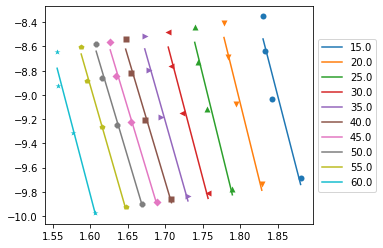

In [39]:
# Stanrink
R = 8.314
rSquared = 0.9

A = 1.0037;
k = 1.8;
C = 0;

df_Stanrink_ModelFree = getModelFree(dfIsoConvDict, R, alpha, A, k, C)
df_Stanrink_best = bestModelPlot(df_Stanrink_ModelFree, rSquared)

In [40]:
df_Stanrink_ModelFree

,a,X,Y,Coeff,YPred,R2,Ea,ko
0,0.0,"[3.302051895047583, 3.28844604482152, 3.326602...","[-8.674342278815166, -7.988627181664834, -7.56...","[13.565075239627978, -6.5128196588399225]","[-7.940593256947539, -7.851980808120006, -8.10...",0.101488,53.947975,3.475117e+06
1,5.0,"[2.6797691534691794, 2.721536684959922, 2.7552...","[-9.050206412448157, -8.329220387900374, -7.90...","[-46.992520036188054, 14.262766050990782]","[-8.771599529595534, -8.17587899941568, -7.694...",0.514600,-118.143506,NaN
2,10.0,"[1.9762827543793888, 1.9283230635692525, 1.942...","[-9.598329759595362, -8.949403065936409, -8.53...","[28.172361604783617, -18.998198818349785]","[-9.373451084191949, -8.462303342914396, -8.72...",0.429288,157.368761,1.806292e+13
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[-9.687849136729376, -9.032095090202827, -8.63...","[35.35663350352023, -23.982096541567707]","[-9.739308767680136, -8.812151029312517, -8.61...",0.914098,198.652138,2.869574e+16
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[-9.738083829178004, -9.07858554107326, -8.684...","[35.950780533438035, -25.011798552612408]","[-9.786978293053508, -8.939906618740629, -8.65...",0.962116,207.181522,5.375989e+16
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[-9.777136205726219, -9.117868979966266, -8.72...","[35.048825682061846, -25.07733806794841]","[-9.824581040264775, -8.98786406202263, -8.683...",0.963954,207.724408,2.186017e+16
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[-9.80999234696684, -9.15274979640499, -8.7620...","[31.473233776915205, -23.521162781122666]","[-9.854257086774357, -9.038064305561992, -8.70...",0.965747,194.834061,5.814812e+14
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[-9.837715591338013, -9.182011546631767, -8.79...","[27.84211196573949, -21.799568370986933]","[-9.875069210909011, -9.098590191107682, -8.73...",0.976015,180.573490,1.449275e+13
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[-9.86067732358921, -9.205424510322318, -8.820...","[25.559486830939235, -20.751740487633715]","[-9.889659041733111, -9.151169287302977, -8.76...",0.986039,171.893963,1.421362e+12
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[-9.881412133939996, -9.225556044724648, -8.84...","[24.7493553818743, -20.520241914688725]","[-9.902854716722619, -9.192340789465621, -8.78...",0.991051,169.976379,6.265725e+11


In [41]:
df_Stanrink_best

,a,X,Y,Coeff,YPred,R2,Ea,ko
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[-9.687849136729376, -9.032095090202827, -8.63...","[35.35663350352023, -23.982096541567707]","[-9.739308767680136, -8.812151029312517, -8.61...",0.914098,198.652138,2.869574e+16
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[-9.738083829178004, -9.07858554107326, -8.684...","[35.950780533438035, -25.011798552612408]","[-9.786978293053508, -8.939906618740629, -8.65...",0.962116,207.181522,5.375989e+16
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[-9.777136205726219, -9.117868979966266, -8.72...","[35.048825682061846, -25.07733806794841]","[-9.824581040264775, -8.98786406202263, -8.683...",0.963954,207.724408,2.186017e+16
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[-9.80999234696684, -9.15274979640499, -8.7620...","[31.473233776915205, -23.521162781122666]","[-9.854257086774357, -9.038064305561992, -8.70...",0.965747,194.834061,5.814812e+14
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[-9.837715591338013, -9.182011546631767, -8.79...","[27.84211196573949, -21.799568370986933]","[-9.875069210909011, -9.098590191107682, -8.73...",0.976015,180.573490,1.449275e+13
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[-9.86067732358921, -9.205424510322318, -8.820...","[25.559486830939235, -20.751740487633715]","[-9.889659041733111, -9.151169287302977, -8.76...",0.986039,171.893963,1.421362e+12
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[-9.881412133939996, -9.225556044724648, -8.84...","[24.7493553818743, -20.520241914688725]","[-9.902854716722619, -9.192340789465621, -8.78...",0.991051,169.976379,6.265725e+11
10,50.0,"[1.6694091435339389, 1.6362039007258782, 1.615...","[-9.902076026130503, -9.245092453775898, -8.86...","[24.728589086768423, -20.75324382246358]","[-9.917065908441515, -9.227949408261722, -8.80...",0.993386,171.906415,6.192634e+11
11,55.0,"[1.6470030524650785, 1.6159169343558961, 1.595...","[-9.926398441557524, -9.267549806987288, -8.88...","[25.519532959243996, -21.526764226870835]","[-9.935113432108324, -9.265929896843296, -8.82...",0.992606,178.313757,1.406346e+12
12,60.0,"[1.6066971017010063, 1.5773530098481554, 1.556...","[-9.9709965418054, -9.311027771727339, -8.9292...","[27.98355454308823, -23.629943607739023]","[-9.982607364824279, -9.289208129121096, -8.80...",0.964095,195.735131,1.780698e+13


In [42]:
df_Stanrink_best[['R2','Ea','ko']].mean()

R2    9.709106e-01
Ea    1.876791e+02
ko    1.049337e+16
dtype: float64

<ipython-input-6-4721a55f28c3>:37: RuntimeWarning: invalid value encountered in double_scalars
  ko = np.exp(coeff[0]+C) * ((Ea / R)**(k-1))


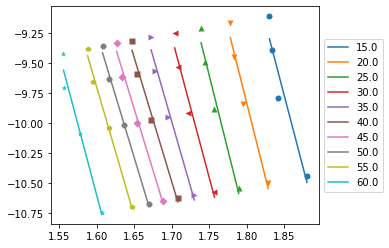

In [43]:
# Stanrink192
R = 8.314
rSquared = 0.9

A = 1.0008;
k = 1.92;
C = 0.312;

df_Stanrink192_ModelFree = getModelFree(dfIsoConvDict, R, alpha, A, k, C)

df_Stanrink192_best = bestModelPlot(df_Stanrink192_ModelFree, rSquared)

In [44]:
df_Stanrink192_ModelFree

,a,X,Y,Coeff,YPred,R2,Ea,ko
0,0.0,"[3.302051895047583, 3.28844604482152, 3.326602...","[-9.359927624898448, -8.674707999975427, -8.24...","[12.759078347934487, -6.4763548550904355]","[-8.626181474317498, -8.538065160148303, -8.78...",0.100470,53.801373,2.647292e+06
1,5.0,"[2.6797691534691794, 2.721536684959922, 2.7552...","[-9.760849367440308, -9.038007419960003, -8.60...","[-47.82150151434187, 14.306928140854298]","[-9.482236801580363, -8.884671729921443, -8.40...",0.516139,-118.852718,NaN
2,10.0,"[1.9762827543793888, 1.9283230635692525, 1.942...","[-10.345514271063992, -9.699535609865105, -9.2...","[27.303812477246723, -18.936787141288683]","[-10.120633373435467, -9.2124309172019, -9.474...",0.427698,157.314597,1.472981e+13
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[-10.441001606673607, -9.787740435749283, -9.3...","[34.481938346182766, -23.91745935859349]","[-10.492460144767783, -9.567801306539138, -9.3...",0.913676,198.690804,2.392841e+16
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[-10.49458527861881, -9.837330250011078, -9.44...","[35.072678335197665, -24.94529970824742]","[-10.54347755660654, -9.698657990926215, -9.41...",0.961924,207.229438,4.490355e+16
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[-10.536241146936906, -9.879232584830286, -9.4...","[34.16808570537215, -25.00936146332882]","[-10.583683631900577, -9.749234724498102, -9.4...",0.963768,207.761622,1.821570e+16
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[-10.57128769759357, -9.916438789031591, -9.52...","[30.59016031445277, -23.4518522268454]","[-10.615549524833103, -9.801761844703083, -9.4...",0.965554,194.822841,4.796022e+14
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[-10.600859158256153, -9.94765132260682, -9.56...","[26.95699707165359, -21.729069696686082]","[-10.638208695846096, -9.864240768952058, -9.4...",0.975866,180.511077,1.181771e+13
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[-10.62535167265743, -9.972625150543408, -9.58...","[24.672687892796013, -20.68024628693612]","[-10.65432806257666, -9.918382563880044, -9.53...",0.985947,171.798129,1.150016e+12
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[-10.647468803698269, -9.994098787239226, -9.6...","[23.861107218114704, -20.447879323100405]","[-10.668905309058722, -9.960896938478385, -9.5...",0.990990,169.867774,5.055033e+11


In [45]:
df_Stanrink192_best

,a,X,Y,Coeff,YPred,R2,Ea,ko
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[-10.441001606673607, -9.787740435749283, -9.3...","[34.481938346182766, -23.91745935859349]","[-10.492460144767783, -9.567801306539138, -9.3...",0.913676,198.690804,2.392841e+16
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[-10.49458527861881, -9.837330250011078, -9.44...","[35.072678335197665, -24.94529970824742]","[-10.54347755660654, -9.698657990926215, -9.41...",0.961924,207.229438,4.490355e+16
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[-10.536241146936906, -9.879232584830286, -9.4...","[34.16808570537215, -25.00936146332882]","[-10.583683631900577, -9.749234724498102, -9.4...",0.963768,207.761622,1.821570e+16
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[-10.57128769759357, -9.916438789031591, -9.52...","[30.59016031445277, -23.4518522268454]","[-10.615549524833103, -9.801761844703083, -9.4...",0.965554,194.822841,4.796022e+14
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[-10.600859158256153, -9.94765132260682, -9.56...","[26.95699707165359, -21.729069696686082]","[-10.638208695846096, -9.864240768952058, -9.4...",0.975866,180.511077,1.181771e+13
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[-10.62535167265743, -9.972625150543408, -9.58...","[24.672687892796013, -20.68024628693612]","[-10.65432806257666, -9.918382563880044, -9.53...",0.985947,171.798129,1.150016e+12
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[-10.647468803698269, -9.994098787239226, -9.6...","[23.861107218114704, -20.447879323100405]","[-10.668905309058722, -9.960896938478385, -9.5...",0.990990,169.867774,5.055033e+11
10,50.0,"[1.6694091435339389, 1.6362039007258782, 1.615...","[-10.669510288701476, -10.014937623560561, -9....","[23.838951132391053, -20.680038216039392]","[-10.684493754096394, -9.99780806385283, -9.57...",0.993341,171.796401,4.995886e+11
11,55.0,"[1.6470030524650785, 1.6159169343558961, 1.595...","[-10.695454198490298, -10.038892133652709, -9....","[24.628320290131644, -21.45259120868183]","[-10.704162913852837, -10.037285129791751, -9....",0.992556,178.214272,1.137851e+12
12,60.0,"[1.6066971017010063, 1.5773530098481554, 1.556...","[-10.743025505421366, -10.085268629375431, -9....","[27.089561277007764, -23.55403076870943]","[-10.754631692454009, -10.06346005007212, -9.5...",0.963873,195.671674,1.453207e+13


In [46]:
df_Stanrink192_best[['R2','Ea','ko']].mean()

R2    9.707496e-01
Ea    1.876364e+02
ko    8.755690e+15
dtype: float64

<ipython-input-6-4721a55f28c3>:37: RuntimeWarning: invalid value encountered in double_scalars
  ko = np.exp(coeff[0]+C) * ((Ea / R)**(k-1))


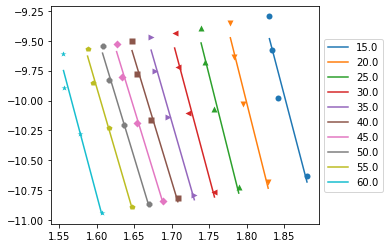

In [47]:
# Stanrink195
R = 8.314
rSquared = 0.9

A = 1;
k = 1.95;
C = 0.235;

df_Stanrink195_ModelFree = getModelFree(dfIsoConvDict, R, alpha, A, k, C)
df_Stanrink195_best = bestModelPlot(df_Stanrink195_ModelFree, rSquared)

In [48]:
df_Stanrink195_ModelFree

,a,X,Y,Coeff,YPred,R2,Ea,ko
0,0.0,"[3.302051895047583, 3.28844604482152, 3.326602...","[-9.53132396141927, -8.846228204553075, -8.418...","[12.55757912501116, -6.467238654153079]","[-8.797578528659994, -8.709586248155382, -8.95...",0.100216,53.768622,2.118017e+06
1,5.0,"[2.6797691534691794, 2.721536684959922, 2.7552...","[-9.938510106188344, -9.21520417797491, -8.785...","[-48.028746883880274, 14.317968663320155]","[-9.659896119576587, -9.061869912547891, -8.57...",0.516523,-119.039591,NaN
2,10.0,"[1.9762827543793888, 1.9283230635692525, 1.942...","[-10.53231039893115, -9.88706874584728, -9.467...","[27.086675195362343, -18.921434222023333]","[-10.307428945746356, -9.39996281077379, -9.66...",0.427300,157.312804,1.198834e+13
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[-10.629289724159666, -9.976651772135899, -9.5...","[34.26326455684846, -23.901300062849973]","[-10.680747989039695, -9.756713875845804, -9.5...",0.913570,198.715409,1.958422e+16
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[-10.683710640979012, -10.027016427245535, -9....","[34.853152785637626, -24.9286749971562]","[-10.732602372494796, -9.888345833972608, -9.6...",0.961876,207.257004,3.676676e+16
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[-10.726017382239577, -10.069573486046291, -9....","[33.94790071119984, -24.992367312173993]","[-10.773459279809536, -9.93957739011698, -9.63...",0.963721,207.786542,1.490604e+16
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[-10.761611535250251, -10.107361037188241, -9....","[30.36939194883693, -23.434524588275956]","[-10.805872634347796, -9.992686229488374, -9.6...",0.965506,194.834637,3.914550e+14
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[-10.79164504998569, -10.139061266600583, -9.7...","[26.735718348132206, -21.711445028110926]","[-10.828993567080378, -10.055653413413157, -9....",0.975829,180.508954,9.618081e+12
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[-10.816520259924486, -10.16442531059868, -9.7...","[24.45098815826022, -20.662372736761732]","[-10.845495317787549, -10.110185883024318, -9....",0.985924,171.786967,9.341349e+11
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[-10.838982971137836, -10.186234472867872, -9....","[23.639045177174825, -20.42978867520334]","[-10.860417957142754, -10.15303597573158, -9.7...",0.990975,169.853263,4.103144e+11


In [49]:
df_Stanrink195_best

,a,X,Y,Coeff,YPred,R2,Ea,ko
3,15.0,"[1.8804003308483241, 1.8417399186212031, 1.833...","[-10.629289724159666, -9.976651772135899, -9.5...","[34.26326455684846, -23.901300062849973]","[-10.680747989039695, -9.756713875845804, -9.5...",0.913570,198.715409,1.958422e+16
4,20.0,"[1.828647337386874, 1.794780453622755, 1.78322...","[-10.683710640979012, -10.027016427245535, -9....","[34.853152785637626, -24.9286749971562]","[-10.732602372494796, -9.888345833972608, -9.6...",0.961876,207.257004,3.676676e+16
5,25.0,"[1.7894007171231525, 1.7560352548091298, 1.743...","[-10.726017382239577, -10.069573486046291, -9....","[33.94790071119984, -24.992367312173993]","[-10.773459279809536, -9.93957739011698, -9.63...",0.963721,207.786542,1.490604e+16
6,30.0,"[1.7570343459744977, 1.7223339874587438, 1.708...","[-10.761611535250251, -10.107361037188241, -9....","[30.36939194883693, -23.434524588275956]","[-10.805872634347796, -9.992686229488374, -9.6...",0.965506,194.834637,3.914550e+14
7,35.0,"[1.7301801822299536, 1.6945611733309174, 1.677...","[-10.79164504998569, -10.139061266600583, -9.7...","[26.735718348132206, -21.711445028110926]","[-10.828993567080378, -10.055653413413157, -9....",0.975829,180.508954,9.618081e+12
8,40.0,"[1.7082492860681757, 1.672662403374157, 1.6539...","[-10.816520259924486, -10.16442531059868, -9.7...","[24.45098815826022, -20.662372736761732]","[-10.845495317787549, -10.110185883024318, -9....",0.985924,171.786967,9.341349e+11
9,45.0,"[1.688684287576176, 1.6540592607265463, 1.6343...","[-10.838982971137836, -10.186234472867872, -9....","[23.639045177174825, -20.42978867520334]","[-10.860417957142754, -10.15303597573158, -9.7...",0.990975,169.853263,4.103144e+11
10,50.0,"[1.6694091435339389, 1.6362039007258782, 1.615...","[-10.86136885434422, -10.207398916006726, -9.8...","[23.616541643796758, -20.66173681443338]","[-10.876350715510121, -10.190272727750617, -9....",0.993330,171.781680,4.055098e+11
11,55.0,"[1.6470030524650785, 1.6159169343558961, 1.595...","[-10.887718137723493, -10.231727715319066, -9....","[24.405517122853773, -21.434047954134723]","[-10.896425284288988, -10.230123938028875, -9....",0.992544,178.202675,9.242503e+11
12,60.0,"[1.6066971017010063, 1.5773530098481554, 1.556...","[-10.936032746325358, -10.278828843787453, -9....","[26.866062960487678, -23.535052558952046]","[-10.947637774361429, -10.257023030309863, -9....",0.963817,195.670427,1.182964e+13


In [50]:
df_Stanrink195_best[['R2','Ea','ko']].mean()

R2    9.707091e-01
Ea    1.876398e+02
ko    7.167260e+15
dtype: float64

### Kissinger

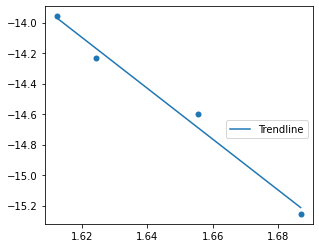

In [54]:
R = 8.314
rSquared = 0.9
A = 1
C = 0
k = 2

dfMaxDict = maximumConversionTemperature(dfeDict, alpha)
Xp=[]
Yp=[]
i = 0
for (B,v) in dfMaxDict.items():
    b = B / 60.0
    T = v + 273.15
    
    x = 1000.0 / T
    y = np.log(b / T**2)
    
    Xp.insert(i,x)
    Yp.insert(i,y)

x = Xp
y = Yp

coeff, stats = npp.polyfit(x,y,1,full=True)

# compute function
yPred = npp.polyval(x, coeff)

# compute R-Squared
SSR = stats[0][0]
SST = np.linalg.norm(y-np.mean(y))**2
#     SST = np.sum((y-np.mean(y))**2)
R2 = 1 - SSR/SST

# compute Ea and ko
Ea = -(coeff[1] * R / A)
ko = np.exp(coeff[0]+C) * ((Ea / R)**(k-1))

markers_cycler = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D','8', 'p','*','h','H','d','+','X',))
    
fig, ax = plt.subplots()

color = next(ax._get_lines.prop_cycler)['color']

ax.plot(x,y,linestyle='', markeredgecolor='none', marker=next(markers_cycler), color=color)
ax.plot(x,yPred,color=color, label='Trendline')
# ax.legend()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

df_Kissinger = pd.DataFrame({
    'a': ['0'],
    'X': 0,
    'Y': 0,
    'Coeff':0,
    'YPred': 0,
    'R2': R2,
    'Ea': Ea,
    'ko': ko
    }
    , dtype=object
)


df_Kissinger.at[0,'X']=x
df_Kissinger.at[0,'Y']=y
df_Kissinger.at[0,'Coeff']=coeff
df_Kissinger.at[0,'YPred']=yPred



In [55]:
df_Kissinger

,a,X,Y,Coeff,YPred,R2,Ea,ko
0,0,"[1.6124013008853697, 1.624412977760162, 1.6553...","[-13.958673728509986, -14.231511906960325, -14...","[12.943852896719996, -16.6925111302215]","[-13.971173764692665, -14.17167881461776, -14....",0.985763,138.782,6.98177e+06


In [56]:
df_Kissinger[['R2','Ea','ko']]

,R2,Ea,ko
0,0.985763,138.782,6.98177e+06
